In [1]:
import sys
sys.executable

'/Applications/anaconda3/envs/kidney/bin/python'

In [2]:
# from bs4 import BeautifulSoup
import numpy as np
from collections import Counter
import pandas as pd
import os
import re
import json
import openslide
from matplotlib import pyplot as plt
import cv2

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../slideslicer/')

In [4]:
from extract_rois_svs_xml import RoiReader, extract_rois_svs_xml, get_threshold_tissue_mask
import slideutils as slu

## Background

The histologic slides are huge. Loading a whole slide into memory might be not the best idea. Here we use some tricks to sample tissue based on hand-labelled features as well as grid sampling in combination with color thresholding (to remove blank space)

## Read XML ROI, convert, and save as JSON

In [5]:
fnxml  = "/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.xml"
# fnxml  = "/Users/dlituiev/repos/kidney_histopath/data/raw/7b1f872d00041bfa4a316bb765e596f9be05931d.xml"
fnsvs = re.sub(".xml$", ".svs", fnxml)
fnsvs

'/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.svs'

In [6]:
rreader = RoiReader(fnxml, threshold_tissue=True, save=True, verbose=True)

counts of roi names
open glom                                 33
infl                                      33
tissue                                     3
capsular tissue                            1
tubular profile excluded from the infl     1
dtype: int64
counts of roi names after removing empty chunks
open glom                                 33
infl                                      33
tissue                                     2
capsular tissue                            1
tubular profile excluded from the infl     1
dtype: int64


In [7]:
rreader

,counts
open glom,33
infl,33
tissue,2
capsular tissue,1
tubular profile excluded from the infl,1


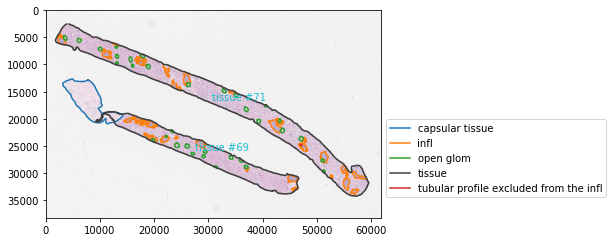

In [8]:
rreader.plot(labels=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# Inspect ROIs as a `pandas` dataframe

In [9]:
rreader.df.head()

,analyze,area,areamicrons,displayid,id,imagefocus,imagelocation,inputregionid,length,lengthmicrons,name,negativeroa,selected,type,vertices,zoom,polygon
0,1.0,1729228.5,110249.1,1.0,1,-1.0,,0.0,8163.4,2061.3,infl,0.0,0.0,0.0,"[(2303.0, 4610.0), (2303.0, 4614.0), (2303.0, ...",0.277228,"POLYGON ((2303 4610, 2303 4614, 2303 4621, 230..."
1,1.0,406998.5,25948.7,2.0,2,-1.0,,0.0,2475.8,625.1,open glom,0.0,0.0,0.0,"[(3353.0, 4732.0), (3353.0, 4728.0), (3360.0, ...",0.277228,"POLYGON ((3353 4732, 3353 4728, 3360 4718, 337..."
2,1.0,434205.5,27683.3,3.0,3,-1.0,,0.0,2431.2,613.9,open glom,0.0,0.0,0.0,"[(5920.0, 5233.0), (5920.0, 5236.0), (5912.0, ...",0.336634,"POLYGON ((5920 5233, 5920 5236, 5912 5241, 590..."
3,1.0,326631.0,20824.8,4.0,4,-1.0,,0.0,2080.4,525.3,open glom,0.0,0.0,0.0,"[(9888.0, 6888.0), (9880.0, 6897.0), (9877.0, ...",0.336634,"POLYGON ((9888 6888, 9880 6897, 9877 6903, 984..."
4,1.0,1741169.0,111010.4,5.0,5,-1.0,,0.0,9939.7,2509.8,infl,0.0,0.0,0.0,"[(10765.0, 7185.0), (10762.0, 7185.0), (10744....",0.336634,"POLYGON ((10765 7185, 10762 7185, 10744 7197, ..."


## save ROIs as a JSON file

In [10]:
json_filename = rreader.save()
print(json_filename)

/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.json


In [11]:
df_tissues = rreader.df[rreader.df.name == 'tissue']
df_tissues.polygon

68    POLYGON ((11759.4140625 18717.35015772871, 116...
69    POLYGON ((3859.5 2535.89905362776, 3799.195312...
Name: polygon, dtype: object

## Visualize the shape of a tissue piece

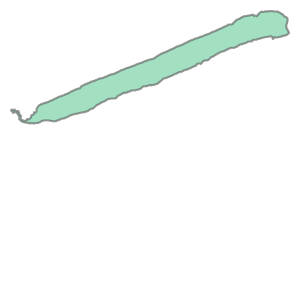

In [12]:
tissue_polygon = df_tissues.polygon.iloc[0]
tissue_polygon

## Sample points within the piece

### Randomly

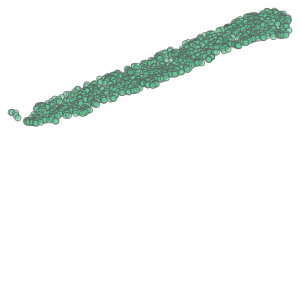

In [13]:
points = slu.sample_points(df_tissues.polygon.iloc[0], n_points=1000, random_seed=42)
points

### On a grid

6 52


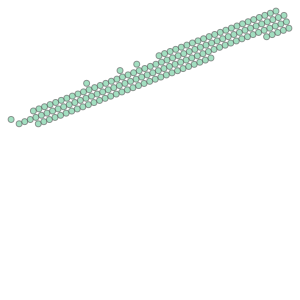

In [17]:
points = slu.sample_points(df_tissues.polygon.iloc[0], n_points=200, mode='grid')
points

[]

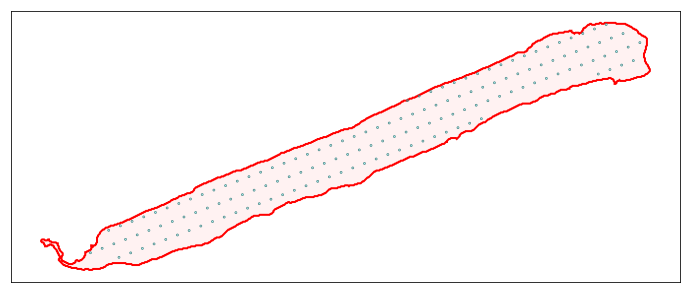

In [15]:
# Visualization using `descartes` and `matplotlib` packages

from shapely.geometry import MultiPoint, Point
import matplotlib.pyplot as plt
from descartes import PolygonPatch

points = MultiPoint([pp for pp in points if isinstance(tissue_polygon & pp, Point)])

fig, ax = plt.subplots(1, figsize=(12,5))

ax.add_patch(PolygonPatch(tissue_polygon, fc=(1,0,0,0.05), ec=(1,0,0,1), lw=2))
ax.add_patch(PolygonPatch(points.buffer(20), fc=(0,1,1,1), ec=(0.2,0.5,0.5,1), lw=2))
ax.relim()
ax.autoscale_view()
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])

## Load and Visualize a patch with a given center point 

In [18]:
xc, yc, _,_ = points[155].bounds
xc, yc

(44939.69144829036, 31282.356186419544)

(256, 256)


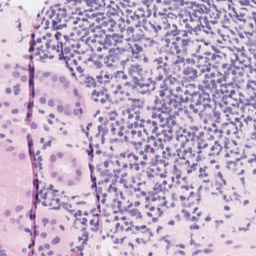

In [19]:
patch = rreader.get_patch(xc, yc, 1024, target_subsample=4)
print(patch.size)
patch

In [20]:
patch_rois = rreader.get_patch_rois(xc, yc, 1024, target_subsample=4)
print(len(patch_rois))
patch_rois

2


,analyze,area,areamicrons,displayid,id,imagefocus,imagelocation,inputregionid,length,lengthmicrons,name,negativeroa,selected,type,vertices,zoom,polygon
41,1.0,37865.44617,1.124184e+05,42.0,42,-1.0,,0.0,6099.3,1540.1,infl,0.0,0.0,0.0,"[[256.0, 163.48178987376286], [256.0, 0.0], [5...",0.336634,"POLYGON ((256 163.4817898737629, 256 0, 57.684..."
68,NaN,65536.00000,7.296906e+06,NaN,69,NaN,NaN,NaN,NaN,NaN,tissue,NaN,NaN,NaN,"[[0.0, 0.0], [0.0, 256.0], [256.0, 256.0], [25...",NaN,"POLYGON ((0 0, 0 256, 256 256, 256 0, 0 0))"


infl
tissue


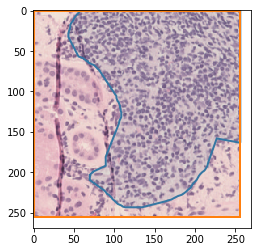

In [21]:
fig,ax, patch, patch_rois = rreader.plot_patch(xc, yc, 1024, target_subsample=4)